# Harmonising Landsat 7 & 8 DE Africa Coeefficients

* **Products used:** 


### Background 

### Description


***

## Getting started


### Load packages
Load key Python packages and any supporting functions for the analysis.

In [1]:
import datacube
import datacube.utils.rio
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

import xarray as xr


from deafrica_tools.datahandling import load_ard
from deafrica_tools.plotting import display_map, rgb
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.dask import create_local_dask_cluster

#This will speed up loading data
datacube.utils.rio.set_default_rio_config(aws='auto', cloud_defaults=True)

/env/lib/python3.8/site-packages/datacube/storage/masking.py:7: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  warnings.warn("datacube.storage.masking has moved to datacube.utils.masking",


In [2]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:41195 Dashboard: /user/chad_extra/proxy/8787/status,Cluster Workers: 1 Cores: 4 Memory: 28.14 GB


### Connect to the datacube
Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [3]:
dc = datacube.Datacube(app="HLS")

### Analysis parameters


In [4]:
# Define the area of interest
#Northern Nigeria
# latitude = 12.24142
# longitude = 9.33816

#Southern Nigeia
# latitude = 8.05477
# longitude = 11.01148

# #Northern Ghana
# latitude = 10.15034
# longitude = 0.34555

#Southen Ghana
# latitude = 6.05653
# longitude = 0.50653

#western ivory coast
# latitude = 9.52254
# longitude = -5.57921

# Guinea Part
# latitude = 10.75481
# longitude = -11.05431

#Guinea Southern 
# latitude = 9.45168
# longitude = -13.46149

# Ethiopia
# latitude = 9.70906
# longitude = 38.62793

#Egypt
latitude= 29.2401
longitude=30.7371

# #kenya
# latitude = -4.39023
# longitude = 33.09082

buffer = 0.01

crop_mask = 'crop_mask_northern'

# Combine central lat,lon with buffer to get area of interest
lat_range = (latitude-buffer, latitude+buffer)
lon_range = (longitude-buffer, longitude+buffer)

# Set the range of dates for the complete sample
time = ('2019')

dask_chunks = dict(x=1000, y=1000)


## View the selected location
The next cell will display the selected area on an interactive map.
The red border represents the area of interest of the study.
Zoom in and out to get a better understanding of the area of interest.
Clicking anywhere on the map will reveal the latitude and longitude coordinates of the clicked point.

In [5]:
display_map(x=lon_range, y=lat_range)

## Load and view Landsat data

In [6]:
#Create a query object
query = {
    'x': lon_range,
    'y': lat_range,
    'time': time,
    'measurements': ['red','nir'],
    'resolution': (-30, 30),
    'group_by': 'solar_day',
    'output_crs': 'EPSG:6933'
}


In [7]:
# load cloud-masked ls8 using load_ard
ds_ls8 = load_ard(dc=dc,
              products=['ls8_sr'],
              min_gooddata=0.95,
              mask_filters=(['opening',5], ['dilation',5]),
              dask_chunks=dask_chunks,
              **query,
             )

/env/lib/python3.8/site-packages/deafrica_tools/datahandling.py:260: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can slow the return of your dataset.
  warnings.warn(


Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls8_sr
Counting good quality pixels for each time step
Filtering to 36 out of 45 time steps with at least 95.0% good quality pixels
Applying morphological filters to pq mask (['opening', 5], ['dilation', 5])
Applying pixel quality/cloud mask
Re-scaling Landsat C2 data
Returning 36 time steps as a dask array


In [8]:
# load cloud-masked fractional cover using load_ard
ds_ls7 = load_ard(dc=dc,
              products=['ls7_sr'],
              like=ds_ls8.geobox,
              time=time,
              measurements=['red','nir'],
              min_gooddata=0.95,
              mask_filters=(['opening',5], ['dilation',5]),
              dask_chunks=dask_chunks
             )

Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls7_sr
Counting good quality pixels for each time step


/env/lib/python3.8/site-packages/deafrica_tools/datahandling.py:260: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can slow the return of your dataset.
  warnings.warn(


Filtering to 33 out of 43 time steps with at least 95.0% good quality pixels
Applying morphological filters to pq mask (['opening', 5], ['dilation', 5])
Applying pixel quality/cloud mask
Re-scaling Landsat C2 data
Returning 33 time steps as a dask array


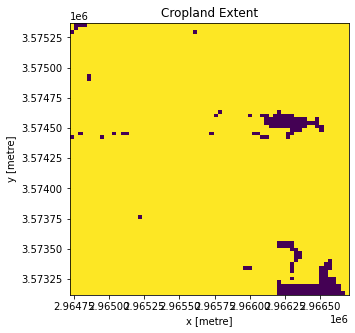

In [9]:
cm = dc.load(product=crop_mask,
            time=('2019'),
            measurements='mask',
            resampling='nearest', 
            like=ds_ls8.geobox).mask.squeeze()

cm.plot.imshow(add_colorbar=False, figsize=(5,5))
plt.title('Cropland Extent');

### Mask non-croplands

In [10]:
ds_ls8 = ds_ls8.where(cm, np.nan)
ds_ls7 = ds_ls7.where(cm, np.nan)

## Match Landsat 7 & 8 acquistion times

Tolerance of 3 days


In [11]:
ds_ls7 = ds_ls7.reindex(time=ds_ls8.time, method='nearest', tolerance='3D')

In [12]:
ds_ls8 = calculate_indices(ds_ls8, 'NDVI', collection='c2', drop=False)
ds_ls7 = calculate_indices(ds_ls7, 'NDVI', collection='s2', drop=False)

### Harmonize Landsat 8 with Sentinel-2 using DE Africa Coefficents


In [13]:
# multiplying the red band with slope and adding to intercept
slope = 0.988
intercept = -0.015
y_dea = (ds_ls7['NDVI'] - intercept) / slope

In [14]:
ndvi_ls8 = ds_ls8.NDVI.mean(dim=['x','y']).compute()
ndvi_ls7 = ds_ls7.NDVI.mean(dim=['x','y']).compute()
ndvi_ls7_adj = y_dea.mean(dim=['x','y']).compute()

### time series plot

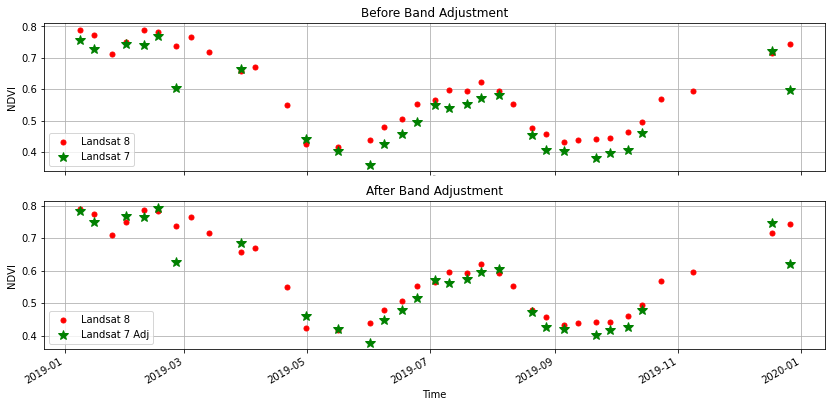

In [15]:
fig, ax = plt.subplots(2,1, sharex=True, figsize=(14, 6))
ndvi_ls8.plot(marker='.', lw=0, color='red', ms=10, label='Landsat 8', ax=ax[0])
ndvi_ls7.plot(marker='*', lw=0, ms=10, color='green', label='Landsat 7', ax=ax[0])
ax[0].legend()
ax[0].title.set_text('Before Band Adjustment')
ax[0].set_xlabel('x-label', fontsize=0)
ax[0].grid()


ndvi_ls8.plot(marker='.', lw=0, color='red', ms=10, label='Landsat 8', ax=ax[1])
ndvi_ls7_adj.plot(marker='*', lw=0, ms=10, color='green', label='Landsat 7 Adj', ax=ax[1])
ax[1].legend()
ax[1].title.set_text('After Band Adjustment')
ax[1].set_xlabel('Time')
ax[1].grid()

plt.show()